In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [13]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0,header=[0, 1, 2])
    genres = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_no_zeroes.csv", index_col=0)
    genres.columns = range(genres.shape[1])
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    curr = genres_index['genre_index']
    late = genres[0].unique().tolist()
    update_genres = {late[i]:curr[i] for i in range(len(curr))}
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right lables
    genres.columns = range(genres.shape[1])
    genres[0]=genres[0].map(update_genres)
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    #generes[0] = generes[0] - 1
    data_y = [targets[i - 1] for i in genres[0]]
    genres[0] = data_y
    # print(genres)
    test = genres.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    # test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(16))
    split.index = genres.index
    genres = split
    return data_x, genres

In [14]:
data, labels = prepareData()
#data = data.reshape(-1, 1, 518)

x_train, x_rest, y_train, y_rest = train_test_split(data, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)

In [15]:
CNN = models.Sequential()
#CNN.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(518,1),padding='SAME'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
# CNN.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
# CNN.add(layers.MaxPooling1D(3))
# CNN.add(layers.Dropout(0.25))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(16,activation='softmax'))

In [16]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 518, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 172, 64)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 172, 64)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 170, 128)          24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 56, 128)          0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 56, 128)          

In [17]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=10,verbose=1),tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=10,verbose=1)]
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [18]:
training = CNN.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), batch_size=389, callbacks=callback)

Epoch 1/100
102/102 [==============================] - 43s 412ms/step - loss: 1.7765 - accuracy: 0.4182 - val_loss: 1.4767 - val_accuracy: 0.5228
Epoch 2/100
102/102 [==============================] - 43s 426ms/step - loss: 1.4273 - accuracy: 0.5463 - val_loss: 1.3095 - val_accuracy: 0.5895
Epoch 3/100
102/102 [==============================] - 43s 419ms/step - loss: 1.3431 - accuracy: 0.5692 - val_loss: 1.2553 - val_accuracy: 0.6065
Epoch 4/100
102/102 [==============================] - 42s 414ms/step - loss: 1.2884 - accuracy: 0.5895 - val_loss: 1.2154 - val_accuracy: 0.6183
Epoch 5/100
102/102 [==============================] - 42s 413ms/step - loss: 1.2544 - accuracy: 0.5973 - val_loss: 1.2105 - val_accuracy: 0.6181
Epoch 6/100
102/102 [==============================] - 42s 415ms/step - loss: 1.2232 - accuracy: 0.6082 - val_loss: 1.1563 - val_accuracy: 0.6369
Epoch 7/100
102/102 [==============================] - 42s 416ms/step - loss: 1.1950 - accuracy: 0.6197 - val_loss: 1.1635 -

In [19]:
x_train.shape

(39678, 518)

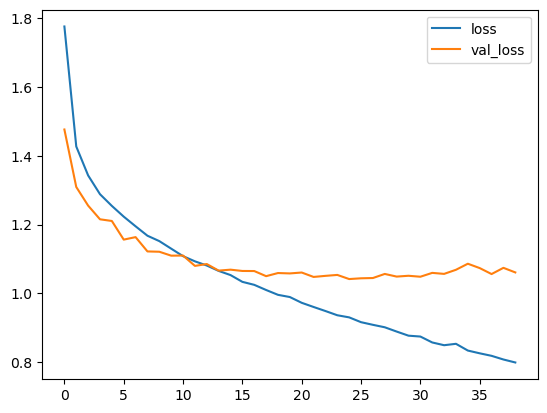

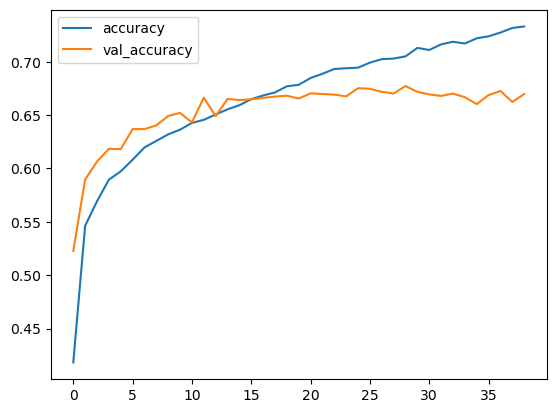

In [20]:
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();# The semicolon prevents certain matplotlib items from being printed.

In [21]:
print(training.history)

{'loss': [1.776458501815796, 1.4272671937942505, 1.343120813369751, 1.2884348630905151, 1.2543575763702393, 1.2231520414352417, 1.194998860359192, 1.167622447013855, 1.1519030332565308, 1.1299642324447632, 1.1081435680389404, 1.0930933952331543, 1.0809043645858765, 1.0652523040771484, 1.0530983209609985, 1.0333845615386963, 1.0246961116790771, 1.0096913576126099, 0.9956281781196594, 0.9891912937164307, 0.9724181890487671, 0.9602786898612976, 0.9484756588935852, 0.9362011551856995, 0.9300132393836975, 0.9160336256027222, 0.9083539247512817, 0.9011930823326111, 0.8887472152709961, 0.8767586946487427, 0.8742519617080688, 0.8570207953453064, 0.8490098118782043, 0.8531047105789185, 0.8334739208221436, 0.8254542350769043, 0.8181212544441223, 0.8074482083320618, 0.7987849712371826], 'accuracy': [0.41824185848236084, 0.5463228821754456, 0.5692071318626404, 0.5894954204559326, 0.5972579121589661, 0.608170747756958, 0.6196632981300354, 0.6258127689361572, 0.6319370865821838, 0.6363223791122437, 

In [22]:
y_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
track_id,,,,,,,,,,,,,,,,
127093,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138930,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4704,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118860,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54624,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
test_loss, test_acc = CNN.evaluate(x_test,y_test)

155/155 [==============================] - 2s 14ms/step - loss: 1.0740 - accuracy: 0.6694


In [24]:
test_acc

0.6693548560142517